In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

#IMG_PATH = "D:/UNIR/TFM/Docs/NoiseCorrec/NoiseCorrec_0100_1000/PNG/work/divided/"
#IMG_PATH_VALID = "D:/UNIR/TFM/Docs/NoiseCorrec/NoiseCorrec_0100_1000/PNG/work/divided/validation/"
#IMG_PATH_TEST = "D:/UNIR/TFM/Docs/NoiseCorrec/NoiseCorrec_0100_1000/PNG/work/divided/test/"

IMG_PATH_TRAIN = IMG_PATH

PERC_TRAIN = 0.8

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 200
hyperparams.BATCH_SIZE = 2 #32

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
SAVED_MODEL = "0100_1000-64-a"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', SAVED_MODEL))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

from tensorflow.keras.optimizers import Adam
hyperparams.OPTIMIZER = Adam(learning_rate=0.005)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelB as train
import ReportsK as reports

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1977634393445810059
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1793668436
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7156417193408683688
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

import ResnetBatchC as model_factory

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.9,
 'epsilon': 1e-07,
 'amsgrad': False}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:9696
Nitid files:9696
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2309
Nitid files:2309


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/200
4848/4848 [==============================] - 55s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/200
4848/4848 [==============================] - 50s 10ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/200
4848/4848 [==============================] - 50s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/200
4848/4848 [==============================] - 50s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/200
4848/4848 [==============================] - 50s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch

Epoch 49/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.9149e-04 - mean_squared_error: 9.9149e-04 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 50/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.9083e-04 - mean_squared_error: 9.9083e-04 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 51/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.7919e-04 - mean_squared_error: 9.7919e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 52/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.9344e-04 - mean_squared_error: 9.9344e-04 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 53/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.8355e-04 - mean_squared_error: 9.8355e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 54/200
4848/4848 [==============================] - 50s 10ms/step - loss: 9.8207e-04 - mean_squared_error: 9.8207e

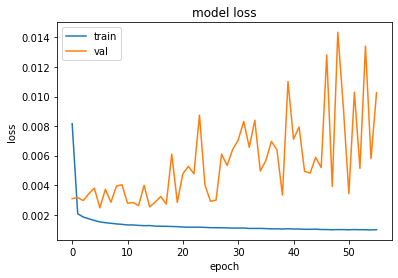

In [8]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [9]:
model.save('C:/Projects/VenusDenoise/saves/0100_1000-64-resnet-a')

INFO:tensorflow:Assets written to: C:/Projects/VenusDenoise/saves/0100_1000-64-resnet-a\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
